In [1]:
from uncertainties import ufloat, umath
from uncertainties import unumpy as unp
import numpy as np
from matplotlib import pyplot as plt
from scipy.odr import ODR,Model,RealData
from scipy import optimize
import sys
import pandas as pd

In [2]:
#paar Unsicherheitsfunktionen
def rechteck(x): #Unsicherheit bei Rechtecksverteilung oder bei zwei Dreiecksverteilungen
    return x/(2*np.sqrt(3))

def dreieck(x): #Unsicherheit bei Dreiecksverteilung
    return x/(2*np.sqrt(6))

def kombUnsicherheit(x,u_mess_rel,offset_u_mess,u_ablese): #Kombination aus Unsicherheit des Messgerätes und Ableseunsicherheit
    u_mess=(x+offset_u_mess)*u_mess_rel
    return np.sqrt(u_mess**2+u_ablese**2)

def rel_abweichung(messwert,theoriewert):
  return (messwert-theoriewert)/theoriewert

def rel_unsicherheit(x):
  return x.s/x.n

def mittelwert(uarray):
  t_factor=np.array([1.84,1.32,1.2,1.14,1.11,1.09,1.08,1.07,1.06,1.05])
  length=uarray.size
  mean=uarray.mean()
  if (length<=10):
    mean=ufloat(mean.n,mean.s*t_factor[length-1])
  return mean

def uprint(ufloat):
  print('{:.2uS}'.format(ufloat))

def uarray_print(uarray):
  for ufloat in uarray:
    uprint(ufloat)

In [3]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')
pdfs_dir = '/content/gdrive/My Drive/Uni/Praktikum/W1'

ModuleNotFoundError: No module named 'google'

# 3.1.1 Temperaturerhöhung des Kühlwassers messen, daraus Reibungsarbeit pro Umlauf bestimmen
*sometimes it feels like it's a trick*

*everything is not as it seems*

*if only I could find a pair of glasses*

*to help me see the ones, who truly be*

*they live and we sleep*

In [5]:
#frequenz, abgelesene frequenz 
f_abgelesen = ufloat(3.1975, dreieck(0.02))
print ('{:.2uS}'.format(f_abgelesen))

3.1975(41)


In [6]:
#Volumendurchfluss bestimmen

#unsicherheiten 
#u_reaktion =
u_ablese = dreieck(2e-6)
u_time= 0.11868679604553978
vol_time = mittelwert(unp.uarray([12.16, 12.15, 12.28],u_time ))
vol_durch = (ufloat(50e-6, u_ablese ))/ vol_time 

vol_durch_p_umlauf = vol_durch / f_abgelesen
print ('{:.2uS}'.format(vol_durch))
print ('{:.2uS}'.format(vol_durch_p_umlauf))

4.099(43)e-06
1.282(14)e-06


In [7]:
#temperaturdifferenz und reibungsarbeit
u_gereat_thermo = 0.05
u_ablese_thermo = rechteck(0.1)
T_reservoir = 22.7
T_kolben = 23.2
T_reservoir_komb = ufloat( T_reservoir,kombUnsicherheit(T_reservoir, u_gereat_thermo, 0, u_ablese_thermo ))
print ('{:.2uS}'.format(T_reservoir_komb))
T_kolben_komb = ufloat( T_kolben,kombUnsicherheit(T_kolben, u_gereat_thermo, 0, u_ablese_thermo ))
print ('{:.2uS}'.format(T_kolben_komb))
delta_T = T_reservoir_komb - T_kolben_komb
print ('{:.2uS}'.format(delta_T))
m_durch_p_umlauf= vol_durch_p_umlauf* 1000
w_reib = 4190 * delta_T * m_durch_p_umlauf

uprint(w_reib)
p_reib= w_reib* f_abgelesen

uprint(p_reib)
uprint(m_durch_p_umlauf)

22.7(1.1)
23.2(1.2)
-0.5(1.6)
-2.7(8.7)
-9(28)
0.001282(14)


# 3.1.2 Wasser abkühlen, Temperaturkurve vermessen, daraus Schmelzwärem von Wasser bestimmen, Kühlleistung und Leistungszahl der Kältemaschine bestimmen


In [8]:
TEMPERATUR_GEFRIER = 273.15
u_thermometer_pasco = 0.5
#DOCH ZEITINTERVALL MITEINBEZIEHEN???

u_zeit_pasco =0 #= rechteck(0.1)??? wegen +- 1 frequenzintervall

path_csv_abkuehlung= pdfs_dir+"/Temperatur_Kuehlungsleistung.csv"
df_abkuehlung=pd.read_csv(path_csv_abkuehlung,sep=";",decimal=',')
print(df_abkuehlung)
print(df_abkuehlung.columns)

zeit_abkuehlung = unp.uarray(df_abkuehlung['Zeit (s) Messreihe #1'].tolist(),u_zeit_pasco)
temperatur_abkuehlung=unp.uarray(df_abkuehlung['Temperatur (°C) Messreihe #1'],u_thermometer_pasco)

NameError: name 'pdfs_dir' is not defined

In [ ]:
def gerade(beta,x):
  #beta[0] ist Steigung, beta[1] ist y-Achsenabschnitt
  return beta[0]*x + beta[1]

model_gerade=Model(gerade)

#ODR-Fit 1
maske_abkuehlung = (15<= zeit_abkuehlung)&(zeit_abkuehlung<=100)
fitintervall_zeit_abkuehlung = zeit_abkuehlung[maske_abkuehlung]
fitintervall_temperatur_abkuehlung = temperatur_abkuehlung[maske_abkuehlung]
data_kuehlung=RealData(unp.nominal_values(fitintervall_zeit_abkuehlung),
                     unp.nominal_values(fitintervall_temperatur_abkuehlung),
                     #sx=unp.std_devs(fitintervall_zeit_abkuehlung),
                     sy=unp.std_devs(fitintervall_temperatur_abkuehlung))
odr_kuehlung= ODR(data_kuehlung, model_gerade,[ 1,1])
odr_kuehlung.set_job(fit_type=0)
output_kuehlung=odr_kuehlung.run()
output_kuehlung.pprint()
beta_kuehlung = output_kuehlung.beta
beta_kuehlung_err=output_kuehlung.sd_beta


steigung_kuehlung= ufloat(beta_kuehlung[0],beta_kuehlung_err[0])
uprint(steigung_kuehlung)


Beta: [-0.14329506 26.76766789]
Beta Std Error: [0.00025289 0.01581289]
Beta Covariance: [[ 5.26769697e-07 -3.02892579e-05]
 [-3.02892579e-05  2.05953302e-03]]
Residual Variance: 0.12140981431231034
Inverse Condition #: 0.006230330244358447
Reason(s) for Halting:
  Sum of squares convergence
-0.14330(25)


### Plot

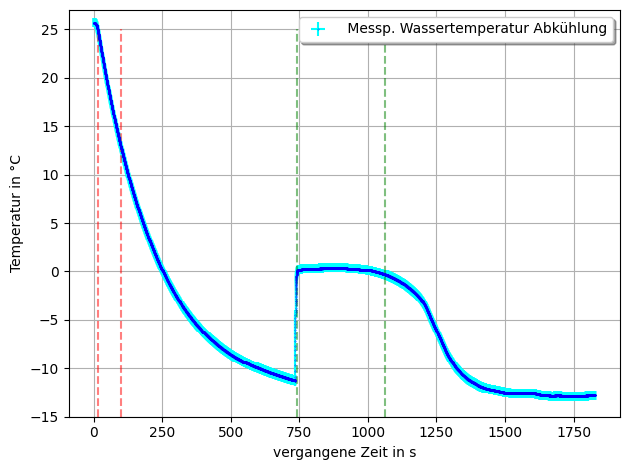

In [ ]:
plt.figure()

plt.errorbar(unp.nominal_values(zeit_abkuehlung),unp.nominal_values(temperatur_abkuehlung),
             xerr =unp.std_devs(zeit_abkuehlung),yerr=unp.std_devs(temperatur_abkuehlung),
             linestyle="",marker=".", markersize = 0.5, color="blue", ecolor= "cyan", label = " Messp. Wassertemperatur Abkühlung")
plt.vlines([15, 100], -15, 25, color = "red", linestyle = "dashed", alpha = 0.5)
plt.vlines([740, 1063], -15, 25, color = "green", linestyle = "dashed", alpha = 0.5)
plt.ylim(-15, 27)
plt.grid()
plt.xlabel("vergangene Zeit in s") 
plt.ylabel("Temperatur in °C")
plt.legend(fancybox=True,shadow=True)
plt.tight_layout()
plt.savefig(f"{pdfs_dir}/plot_abkuehlung.pdf")

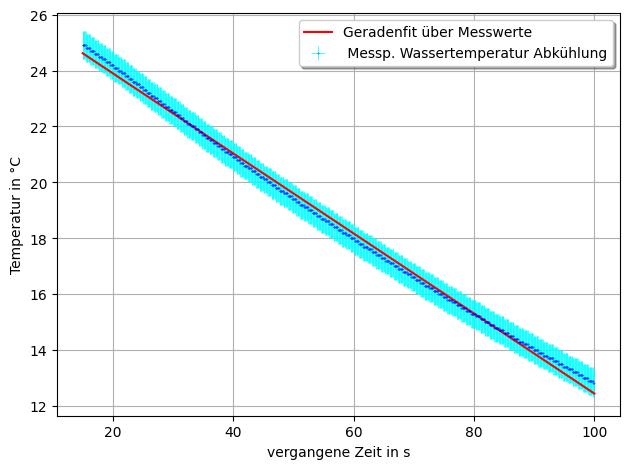

In [ ]:
plt.figure()

x_int_kuehl=np.linspace(15,100,10000)
plt.errorbar(unp.nominal_values(zeit_abkuehlung[150: 1000]),unp.nominal_values(temperatur_abkuehlung[150: 1000]),
             xerr =unp.std_devs(zeit_abkuehlung[150: 1000]),yerr=unp.std_devs(temperatur_abkuehlung[150: 1000]),
             linestyle="",marker=".", markersize = 0.5, ecolor= "cyan", elinewidth= 0.5, color="blue", label = " Messp. Wassertemperatur Abkühlung")
plt.plot(x_int_kuehl,gerade(beta_kuehlung,x_int_kuehl),marker="",color="red",label="Geradenfit über Messwerte")

plt.grid()
plt.xlabel("vergangene Zeit in s") 
plt.ylabel("Temperatur in °C")
plt.legend(fancybox=True,shadow=True)
plt.tight_layout()
plt.savefig(f"{pdfs_dir}/plot_abkuehlung_steigung.pdf")

Wassermenge im Reagenzglas

In [ ]:
v_reagenz = 0.9e-6
#unsicherheiten
u_ablese_reagenz = dreieck(0.02e-6)
#5 % für wasserrückstände etc.
u_sons_reagenz = 0.1

v_reagenz_komb = ufloat(v_reagenz, kombUnsicherheit(v_reagenz, u_sons_reagenz, 0 , u_ablese_reagenz))
uprint(v_reagenz_komb)
#Annahme dichte = 1000
m_reagenz_komb = v_reagenz_komb*1000
kuehlleistung= 4190*steigung_kuehlung* m_reagenz_komb
uprint(kuehlleistung)

#schmelzwärme 
u_ablese_plateau_anfang_kuehl = 2
u_ablese_plateau_ende_kuehl = 10
t_plateau_kuehl = ufloat(1063, u_ablese_plateau_ende_kuehl)- ufloat(740, u_ablese_plateau_anfang_kuehl)
Q_s_k = t_plateau_kuehl*kuehlleistung

uprint(t_plateau_kuehl)
uprint(Q_s_k)
uprint(Q_s_k/m_reagenz_komb)

9.00(90)e-07
-0.540(54)
323(10)
-175(18)
-1.939(61)e+05


Unsicherheit Temperaturmessung

# 3.1.3 Temperaturkurve bei Erwärmung messen, Heizleistung des Motors bestimmen, spez. Wärme von Eis abschätzen

In [ ]:
path_csv_erhitzung= pdfs_dir+"/Temperatur_Heizleistung.csv"
df_erhitzung=pd.read_csv(path_csv_erhitzung,sep=";",decimal=',')
print(df_erhitzung)
print(df_erhitzung.columns)

zeit_erhitzung = unp.uarray(df_erhitzung['Zeit (s) Messreihe #1'].tolist(),u_zeit_pasco)
temperatur_erhitzung=unp.uarray(df_erhitzung['Temperatur (°C) Messreihe #1'],u_thermometer_pasco)

      Zeit (s) Messreihe #1  Temperatur (°C) Messreihe #1
0                       0.0                         -12.8
1                       0.1                         -12.8
2                       0.2                         -12.8
3                       0.3                         -12.8
4                       0.4                         -12.8
...                     ...                           ...
3064                  306.4                          29.1
3065                  306.5                          29.1
3066                  306.6                          29.2
3067                  306.7                          29.2
3068                  306.8                          29.2

[3069 rows x 2 columns]
Index(['Zeit (s) Messreihe #1', 'Temperatur (°C) Messreihe #1'], dtype='object')


In [ ]:
#ODR-Fit 2
maske_erhitzung = (250<= zeit_erhitzung)&(zeit_erhitzung<=275)
fitintervall_zeit_erhitzung = zeit_erhitzung[maske_erhitzung]
fitintervall_temperatur_erhitzung = temperatur_erhitzung[maske_erhitzung]
data_erhitzung=RealData(unp.nominal_values(fitintervall_zeit_erhitzung),
                     unp.nominal_values(fitintervall_temperatur_erhitzung),
                     #sx=unp.std_devs(fitintervall_zeit_erhitzung),
                     sy=unp.std_devs(fitintervall_temperatur_erhitzung))
odr_erhitzung= ODR(data_erhitzung, model_gerade,[ 1,1])
odr_erhitzung.set_job(fit_type=0)
output_erhitzung=odr_erhitzung.run()
output_erhitzung.pprint()
beta_erhitzung = output_erhitzung.beta
beta_erhitzung_err=output_erhitzung.sd_beta


steigung_erhitzung= ufloat(beta_erhitzung[0],beta_erhitzung_err[0])
uprint(steigung_erhitzung)

Beta: [  0.27094626 -52.60905121]
Beta Std Error: [0.00056077 0.14725779]
Beta Covariance: [[ 2.45440797e-05 -6.44282088e-03]
 [-6.44282088e-03  1.69252896e+00]]
Residual Variance: 0.012812104219633674
Inverse Condition #: 0.0001046824267634851
Reason(s) for Halting:
  Sum of squares convergence
0.27095(56)


### Plot

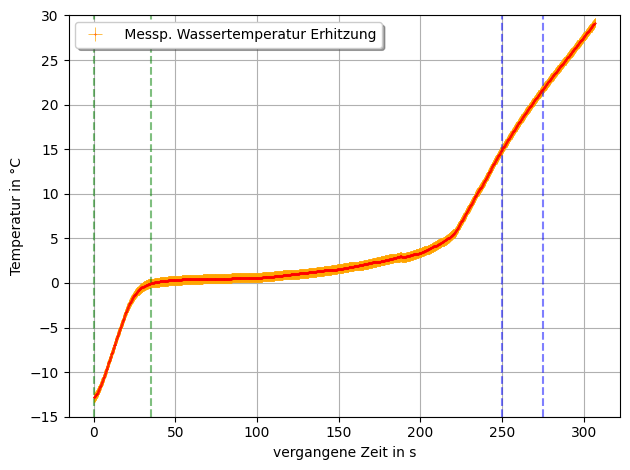

In [ ]:
plt.figure()

plt.errorbar(unp.nominal_values(zeit_erhitzung),unp.nominal_values(temperatur_erhitzung),
             xerr =unp.std_devs(zeit_erhitzung),yerr=unp.std_devs(temperatur_erhitzung),
             linestyle="",marker=".", color="red",  markersize = 0.5, ecolor= "orange", elinewidth= 0.5, label = " Messp. Wassertemperatur Erhitzung")
plt.vlines([250, 275], -15, 30, color = "blue", linestyle = "dashed", alpha = 0.5)
plt.vlines([0, 35], -15, 30, color = "green", linestyle = "dashed", alpha = 0.5)
plt.ylim(-15,30)
plt.grid()
plt.xlabel("vergangene Zeit in s") 
plt.ylabel("Temperatur in °C")
plt.legend(fancybox=True,shadow=True)
plt.tight_layout()
plt.savefig(f"{pdfs_dir}/plot_erhitzung.pdf")

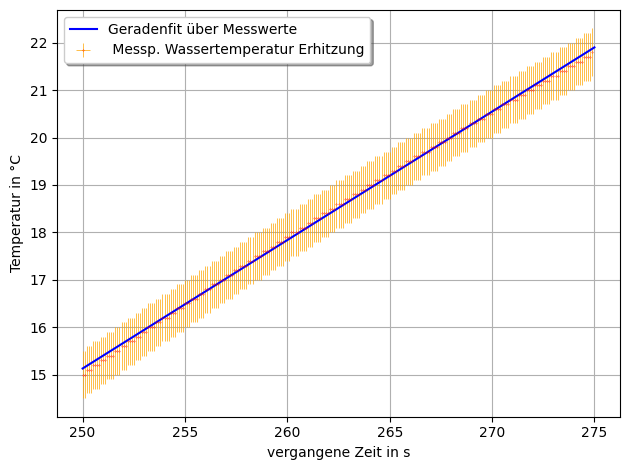

In [ ]:
#geradenplot
plt.figure()

x_int_heiz=np.linspace(250,275,10000)
plt.errorbar(unp.nominal_values(zeit_erhitzung[2500: 2750]),unp.nominal_values(temperatur_erhitzung[2500: 2750]),
             xerr =unp.std_devs(zeit_erhitzung[2500: 2750]),yerr=unp.std_devs(temperatur_erhitzung[2500: 2750]),
             linestyle="",marker=".", markersize = 0.5, ecolor= "orange", elinewidth= 0.5, color="red", label = " Messp. Wassertemperatur Erhitzung")
plt.plot(x_int_heiz,gerade(beta_erhitzung,x_int_heiz),marker="",color="blue",label="Geradenfit über Messwerte")


plt.grid()
plt.xlabel("vergangene Zeit in s") 
plt.ylabel("Temperatur in °C")
plt.legend(fancybox=True,shadow=True)
plt.tight_layout()
plt.savefig(f"{pdfs_dir}/plot_erhitzung_steigung.pdf")

In [ ]:
heizleistung= 4190*steigung_erhitzung* m_reagenz_komb
uprint(heizleistung)

#schmelzwärme 
#u_ablese_plateau_anfang_heiz = 5
#u_ablese_plateau_ende_heiz = 20
#t_plateau_heiz = ufloat(100, u_ablese_plateau_ende_heiz)- ufloat(30, u_ablese_plateau_anfang_heiz)
#Q_s_h = t_plateau_heiz*heizleistung
#uprint(t_plateau_heiz)
#uprint(Q_s_h)


1.02(10)


In [ ]:
#ODR-Fit spez. Wärme
maske_erhitzung_spez = (0<= zeit_erhitzung)&(zeit_erhitzung<=35)
fitintervall_zeit_erhitzung_spez = zeit_erhitzung[maske_erhitzung_spez]
fitintervall_temperatur_erhitzung_spez = temperatur_erhitzung[maske_erhitzung_spez]
data_erhitzung_spez=RealData(unp.nominal_values(fitintervall_zeit_erhitzung_spez),
                     unp.nominal_values(fitintervall_temperatur_erhitzung_spez),
                     #sx=unp.std_devs(fitintervall_zeit_erhitzung),
                     sy=unp.std_devs(fitintervall_temperatur_erhitzung_spez))
odr_erhitzung_spez= ODR(data_erhitzung_spez, model_gerade,[ 1,1])
odr_erhitzung_spez.set_job(fit_type=0)
output_erhitzung_spez=odr_erhitzung_spez.run()
output_erhitzung_spez.pprint()
beta_erhitzung_spez = output_erhitzung_spez.beta
beta_erhitzung_spez_err=output_erhitzung_spez.sd_beta


steigung_erhitzung_spez= ufloat(beta_erhitzung_spez[0],beta_erhitzung_spez_err[0])
uprint(steigung_erhitzung_spez)


Beta: [  0.42412071 -12.67567378]
Beta Std Error: [0.00419534 0.08477354]
Beta Covariance: [[ 1.20004235e-05 -2.10007179e-04]
 [-2.10007179e-04  4.89984495e-03]]
Residual Variance: 1.4666899853060142
Inverse Condition #: 0.024274368527803715
Reason(s) for Halting:
  Sum of squares convergence
0.4241(42)


In [ ]:
#ODR-Fit spez. Wärme optimiert für lineares Intervall
maske_erhitzung_spez_opt = (5<= zeit_erhitzung)&(zeit_erhitzung<=20)
fitintervall_zeit_erhitzung_spez_opt = zeit_erhitzung[maske_erhitzung_spez_opt]
fitintervall_temperatur_erhitzung_spez_opt = temperatur_erhitzung[maske_erhitzung_spez_opt]
data_erhitzung_spez_opt=RealData(unp.nominal_values(fitintervall_zeit_erhitzung_spez_opt),
                     unp.nominal_values(fitintervall_temperatur_erhitzung_spez_opt),
                     #sx=unp.std_devs(fitintervall_zeit_erhitzung),
                     sy=unp.std_devs(fitintervall_temperatur_erhitzung_spez_opt))
odr_erhitzung_spez_opt= ODR(data_erhitzung_spez_opt, model_gerade,[ 1,1])
odr_erhitzung_spez_opt.set_job(fit_type=0)
output_erhitzung_spez_opt=odr_erhitzung_spez_opt.run()
output_erhitzung_spez_opt.pprint()
beta_erhitzung_spez_opt = output_erhitzung_spez_opt.beta
beta_erhitzung_spez_opt_err=output_erhitzung_spez_opt.sd_beta


steigung_erhitzung_spez_opt= ufloat(beta_erhitzung_spez_opt[0],beta_erhitzung_spez_opt_err[0])
uprint(steigung_erhitzung_spez_opt)

Beta: [  0.54207451 -13.90308367]
Beta Std Error: [0.00079867 0.01057296]
Beta Covariance: [[ 0.00018958 -0.00236971]
 [-0.00236971  0.03322301]]
Residual Variance: 0.0033647588087775647
Inverse Condition #: 0.023741801698318115
Reason(s) for Halting:
  Sum of squares convergence
0.54207(80)


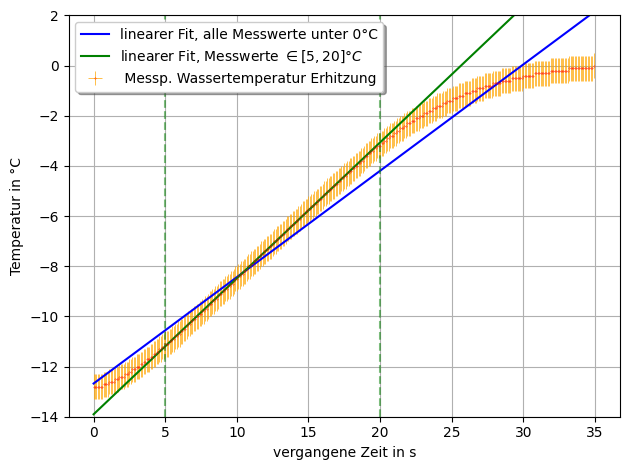

In [ ]:
#geradenplot für spez wärme v Eis
plt.figure()

x_int_heiz_spez =np.linspace(0,35,10000)
plt.errorbar(unp.nominal_values(zeit_erhitzung[0: 350]),unp.nominal_values(temperatur_erhitzung[0: 350]),
             xerr =unp.std_devs(zeit_erhitzung[0: 350]),yerr=unp.std_devs(temperatur_erhitzung[0: 350]),
             linestyle="",marker=".", markersize = 0.5, ecolor= "orange", elinewidth= 0.5, color="red", label = " Messp. Wassertemperatur Erhitzung")
plt.plot(x_int_heiz_spez,gerade(beta_erhitzung_spez,x_int_heiz_spez),marker="",color="blue",label="linearer Fit, alle Messwerte unter 0°C")
plt.plot(x_int_heiz_spez,gerade(beta_erhitzung_spez_opt,x_int_heiz_spez),marker="",color="green",label="linearer Fit, Messwerte $\in [5,20]°C$")
plt.vlines([5, 20], -14, 2, color = "green", linestyle = "dashed", alpha = 0.5)
plt.ylim(-14, 2)
plt.grid()
plt.xlabel("vergangene Zeit in s") 
plt.ylabel("Temperatur in °C")
plt.legend(fancybox=True,shadow=True)
plt.tight_layout()
plt.savefig(f"{pdfs_dir}/plot_steigung_spez_eis.pdf")

In [ ]:

#spezifische wärmekapazität v eis

#durchflossene Masse im Zeitintervall

c_eis = heizleistung /(m_reagenz_komb * steigung_erhitzung_spez_opt)
uprint(c_eis)




2094.3(5.3)


### Leistungszahlen

In [ ]:
#temperaturen nach kuehlung 
T_reservoir_kuehl =  ufloat( 23.3,kombUnsicherheit(23.3, u_gereat_thermo, 0, u_ablese_thermo ))
T_kolben_kuehl = ufloat( 24.3,kombUnsicherheit(24.3, u_gereat_thermo, 0, u_ablese_thermo ))
T_diff_kuehl = T_kolben_kuehl - T_reservoir_kuehl 

#leistungszahl kuehlung

p_kw_1 =  (4190* m_durch_p_umlauf* f_abgelesen* 1827* T_diff_kuehl)*f_abgelesen
p_kw_1_opt = (4190* m_durch_p_umlauf* f_abgelesen* 1500* T_diff_kuehl)*f_abgelesen

e_kuehl = kuehlleistung/p_kw_1

e_kuehl_opt = kuehlleistung/p_kw_1_opt
uprint(T_diff_kuehl)
uprint(p_kw_1)
uprint(e_kuehl)
uprint(e_kuehl_opt)
uprint(m_durch_p_umlauf*1827*f_abgelesen)


1.0(1.7)
1.0(1.7)e+05
-5.4(9.1)e-06
-0.7(1.1)e-05
7.490(79)


In [ ]:
#temperaturen nach erhitzung
T_reservoir_heiz =  ufloat( 23.4,kombUnsicherheit(23.4, u_gereat_thermo, 0, u_ablese_thermo ))
T_kolben_heiz = ufloat( 23.6,kombUnsicherheit(23.6, u_gereat_thermo, 0, u_ablese_thermo ))
T_diff_heiz = T_kolben_kuehl - T_reservoir_kuehl 
#leistungszahl erhitzung

p_kw_2 =  (4190* m_durch_p_umlauf* f_abgelesen* 307* T_diff_heiz)*f_abgelesen + 2* p_reib
e_heiz = heizleistung/p_kw_2
uprint(T_reservoir_heiz)
uprint(T_kolben_heiz)
uprint(e_heiz)

23.4(1.2)
23.6(1.2)
0.00006(10)


# Zusammenfassung der wichtigen Ergebnisse